In [4]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.selection import RecursiveFeatureElimination
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import json

In [5]:
filepath = "../data/cr_loan_featured.csv"
df = pd.read_csv(filepath)
df

scaler = StandardScaler()
target_column = "loan_status"
X = df.drop(columns=[target_column])
y = df[target_column]

scaled_df = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)
scaled_df[target_column] = y
scaled_df

,person_age,person_income,person_emp_length,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,person_home_ownership_OTHER,...,loan_intent_PERSONAL,loan_intent_VENTURE,emp_length_age_ratio,emp_length_cred_hist_ratio,income_emp_length_product,cred_hist_age_ratio,emp_start,interest_income_ratio,parent_dependency,loan_status
0,-1.083796,-1.071924,0.059888,-0.188863,-1.359401,0.040702,-0.657856,-0.46339,-0.939218,-0.057284,...,-0.451900,-0.460932,0.484347,1.309119,-0.560220,-1.065093,-1.027609,-0.538204,-0.156314,0
1,-0.439710,-1.071924,-0.944205,0.667799,-0.647465,0.601834,3.743580,-0.46339,-0.692782,-0.057284,...,-0.451900,-0.460932,-0.999210,-0.757052,-0.632362,-0.800493,0.151970,3.874224,-0.156314,1
2,-0.761753,-0.007508,-0.191135,0.667799,4.019675,1.367308,3.368990,-0.46339,-0.939218,-0.057284,...,-0.451900,-0.460932,0.003679,0.832310,-0.158182,-1.153588,-0.585267,4.417328,-0.156314,1
3,-0.600732,-0.218867,0.812958,0.667799,4.019675,1.055929,3.556285,2.15801,-0.446345,-0.057284,...,-0.451900,-0.460932,1.197595,0.832310,0.167206,-0.301824,-1.027609,5.157985,-0.156314,1
4,-1.083796,-1.066211,-0.693182,-1.045525,-1.122089,-1.256711,0.746857,-0.46339,-0.939218,-0.057284,...,-0.451900,2.169519,-0.585526,-0.121307,-0.613199,-1.065093,-0.585267,-0.081826,-0.156314,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32404,4.712979,-0.245525,-0.944205,0.667799,-0.600002,0.695896,-0.564209,-0.46339,5.961011,-0.057284,...,2.212879,-0.460932,-1.167386,-1.043137,-0.550827,3.541303,4.870284,-0.339540,-0.156314,0
32405,4.229914,1.030250,-0.191135,-1.045525,1.270809,-1.143188,-0.189618,-0.46339,3.250207,-0.057284,...,2.212879,-0.460932,-0.744025,-0.874163,0.251371,1.677022,3.985600,-0.581045,-0.156314,0
32406,6.001151,0.192427,-0.442158,-0.188863,4.019675,-0.007951,2.713457,-0.46339,5.468137,-0.057284,...,-0.451900,-0.460932,-0.953123,-0.972751,-0.222057,2.520315,5.754968,2.232084,-0.156314,1
32407,4.551957,1.601493,0.059888,-0.188863,0.855513,0.150983,-0.657856,-0.46339,4.975264,-0.057284,...,2.212879,-0.460932,-0.630104,-0.891537,0.758616,2.878464,4.133047,-0.547023,-0.156314,0


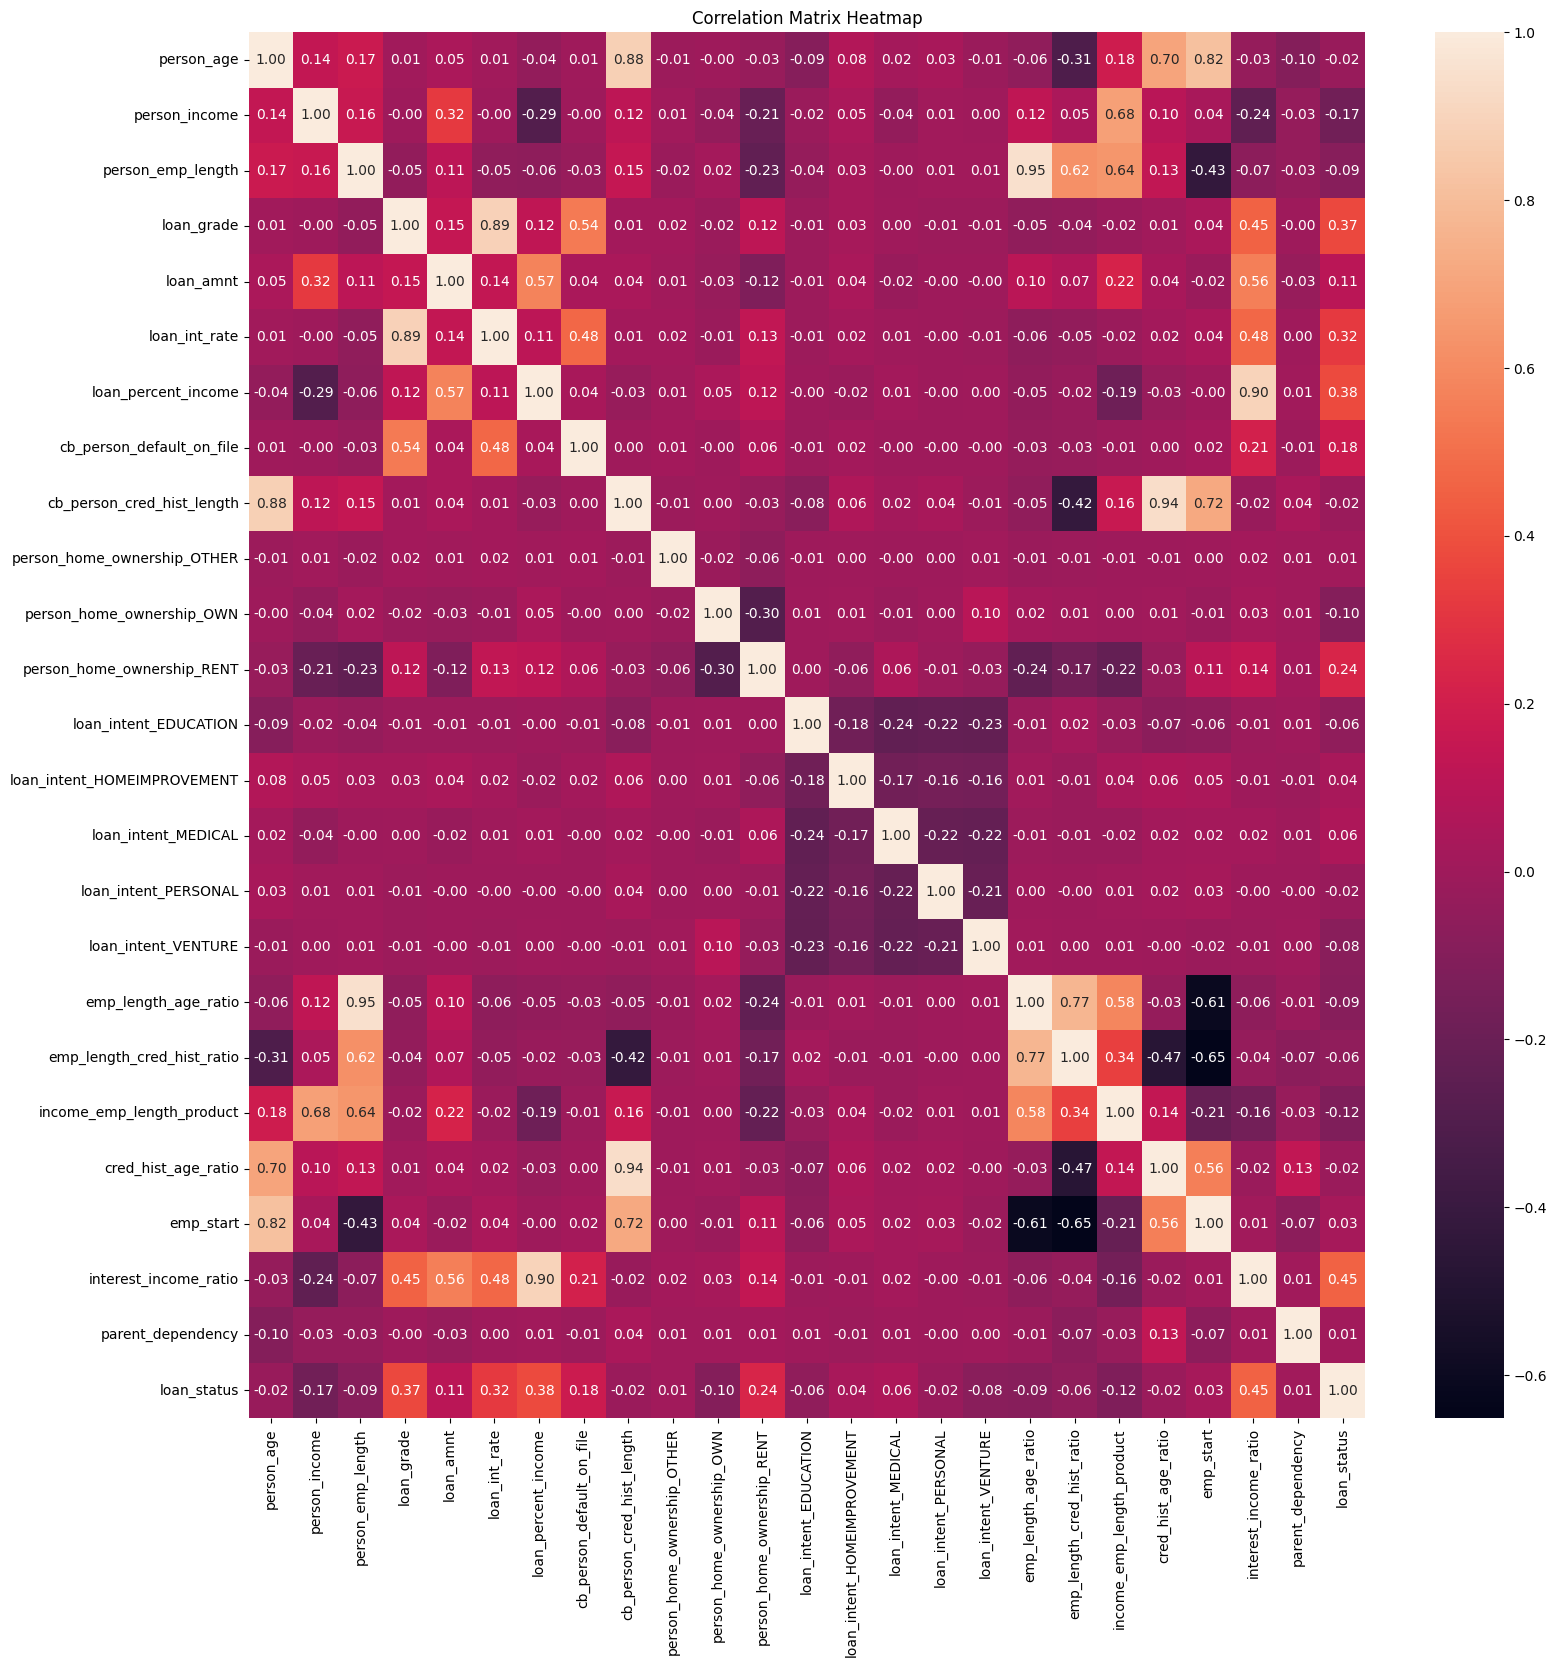

In [6]:
correlation_matrix = scaled_df.corr()

plt.figure(figsize=(18, 18))
sns.heatmap(correlation_matrix, annot=True, fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

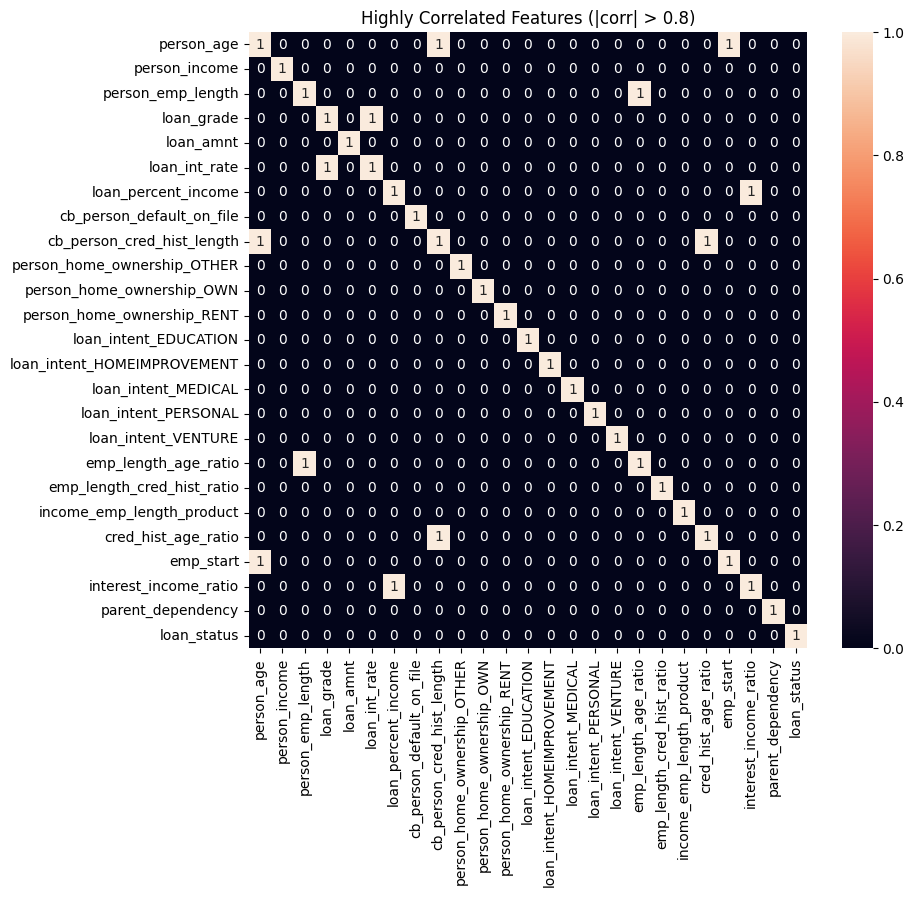

In [7]:
threshold = 0.8
is_correlated = correlation_matrix.abs() > threshold

plt.figure(figsize=(9, 8))
sns.heatmap(is_correlated, annot=True)
plt.title(f'Highly Correlated Features (|corr| > {threshold})')
plt.show()

In [8]:
for column in is_correlated:
    is_correlated.loc[column, column] = False

correlated_pairs = correlation_matrix[is_correlated].stack()

correlated_pairs.sort_values(ascending=False, inplace=True)
correlated_feats = correlated_pairs.index.get_level_values(0).unique()

correlated_pairs

person_emp_length           emp_length_age_ratio          0.952583
emp_length_age_ratio        person_emp_length             0.952583
cb_person_cred_hist_length  cred_hist_age_ratio           0.938877
cred_hist_age_ratio         cb_person_cred_hist_length    0.938877
interest_income_ratio       loan_percent_income           0.895214
loan_percent_income         interest_income_ratio         0.895214
loan_grade                  loan_int_rate                 0.890056
loan_int_rate               loan_grade                    0.890056
cb_person_cred_hist_length  person_age                    0.878240
person_age                  cb_person_cred_hist_length    0.878240
                            emp_start                     0.815488
emp_start                   person_age                    0.815488
dtype: float64

In [10]:
scaler_train = StandardScaler()
scaler_test = StandardScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
scaled_X_train = pd.DataFrame(scaler_train.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

scaled_X_test = pd.DataFrame(scaler_test.fit_transform(X_test), columns=X_test.columns, index=X_test.index)

scaled_X_train_correlated_feats = scaled_X_train[correlated_feats]

In [11]:
dt_model = DecisionTreeClassifier(random_state=42)
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
xgb_model = xgb.XGBClassifier(n_estimators=100, random_state=42)

dt_selector = SelectBySingleFeaturePerformance(estimator=dt_model, scoring='roc_auc', cv=5)
rf_selector = SelectBySingleFeaturePerformance(estimator=rf_model, scoring='roc_auc', cv=5)
xgb_selector = SelectBySingleFeaturePerformance(estimator=xgb_model, scoring='roc_auc', cv=5)

dt_selector.fit(scaled_X_train_correlated_feats, y_train)
rf_selector.fit(scaled_X_train_correlated_feats, y_train)
xgb_selector.fit(scaled_X_train_correlated_feats, y_train)

dt_feat_performance = dt_selector.feature_performance_
rf_feat_performance = rf_selector.feature_performance_
xgb_feat_performance = xgb_selector.feature_performance_

print("Decision Tree Model -", dt_feat_performance)
print("Random Forest Model -", rf_feat_performance)
print("XGBoost Model -", xgb_feat_performance)

Decision Tree Model - {'person_emp_length': np.float64(0.5630761910014026), 'emp_length_age_ratio': np.float64(0.5557219798755888), 'cb_person_cred_hist_length': np.float64(0.5135132464258758), 'cred_hist_age_ratio': np.float64(0.5094408455746748), 'interest_income_ratio': np.float64(0.6602027228222358), 'loan_percent_income': np.float64(0.7223229453504229), 'loan_grade': np.float64(0.7219991531359212), 'loan_int_rate': np.float64(0.7046558536032983), 'person_age': np.float64(0.5167417032962984), 'emp_start': np.float64(0.5283665373601476)}
Random Forest Model - {'person_emp_length': np.float64(0.5619214253056146), 'emp_length_age_ratio': np.float64(0.5556233183014356), 'cb_person_cred_hist_length': np.float64(0.5142565295702028), 'cred_hist_age_ratio': np.float64(0.5106311732840971), 'interest_income_ratio': np.float64(0.7280157063226815), 'loan_percent_income': np.float64(0.7228495317657496), 'loan_grade': np.float64(0.7219991531359212), 'loan_int_rate': np.float64(0.7046948423468551

In [12]:
dt_feats = list(X.columns)
rf_feats = list(X.columns)
xgb_feats = list(X.columns)

def EliminateCorrelatedFeature(feat_performance, feats, correlated_pairs):
    for feat1, feat2 in correlated_pairs.keys():
        if feat1 in feats and feat2 in feats:
            min_performant = feat1 if feat_performance[feat1] < feat_performance[feat2] else feat2
            feats.remove(min_performant)
        
EliminateCorrelatedFeature(dt_feat_performance, dt_feats, correlated_pairs)
EliminateCorrelatedFeature(rf_feat_performance, rf_feats, correlated_pairs)
EliminateCorrelatedFeature(xgb_feat_performance, xgb_feats, correlated_pairs)

In [13]:
dt_rfe = RecursiveFeatureElimination(estimator=dt_model, scoring="roc_auc",cv=5)
rf_rfe = RecursiveFeatureElimination(estimator=rf_model, scoring="roc_auc",cv=5)
xgb_rfe = RecursiveFeatureElimination(estimator=xgb_model, scoring="roc_auc",cv=5)

dt_rfe.fit(scaled_X_train[dt_feats], y_train)
rf_rfe.fit(scaled_X_train[rf_feats], y_train)
xgb_rfe.fit(scaled_X_train[xgb_feats], y_train)

print("Decision Tree Model -", dt_rfe.features_to_drop_)
print("Random Forest Model -", rf_rfe.features_to_drop_)
print("XGBoost Model -", xgb_rfe.features_to_drop_)

for feats in dt_rfe.features_to_drop_:
    dt_feats.remove(feats)
for feats in rf_rfe.features_to_drop_:
    rf_feats.remove(feats)
for feats in xgb_rfe.features_to_drop_:
    xgb_feats.remove(feats)


Decision Tree Model - ['person_emp_length', 'loan_amnt', 'cb_person_default_on_file', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'loan_intent_MEDICAL', 'emp_length_cred_hist_ratio', 'emp_start', 'parent_dependency']
Random Forest Model - ['person_emp_length', 'loan_amnt', 'cb_person_default_on_file', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'emp_length_cred_hist_ratio', 'income_emp_length_product', 'emp_start', 'parent_dependency']
XGBoost Model - ['person_emp_length', 'loan_amnt', 'cb_person_default_on_file', 'person_home_ownership_OTHER', 'person_home_ownership_OWN', 'loan_intent_EDUCATION', 'loan_intent_HOMEIMPROVEMENT', 'loan_intent_MEDICAL', 'loan_intent_PERSONAL', 'loan_intent_VENTURE', 'emp_length_cred_hist_ratio', 'income_emp_length_product', 'emp_start', 'parent_dependency']


In [14]:
feats = {"dt_feats": dt_feats,
         "rf_feats": rf_feats,
         "xgb_feats": xgb_feats}

file_path = '../model_features.json'
with open(file_path, 'w') as f:
    json.dump(feats, f, indent=4)

In [15]:
scaled_df_train = scaled_X_train
scaled_df_train[target_column] = y_train
scaled_df_train.to_csv("../data/cr_loan_train.csv",index=False)

scaled_df_test = scaled_X_test
scaled_df_test[target_column] = y_test
scaled_df_test.to_csv("../data/cr_loan_test.csv", index=False)


joblib.dump(scaler_train, "../models_and_scalers/scaler_train.pkl")
joblib.dump(scaler_test, "../models_and_scalers/scaler_test.pkl")

['../models_and_scalers/scaler_test.pkl']